In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
from google.colab import userdata
token = userdata.get('Cryptonite-Token')

In [13]:
!git clone https://{token}@github.com/SILETRO/Cryptonite-RTP-Idant.git
%cd Cryptonite-RTP-Idant

Cloning into 'Cryptonite-RTP-Idant'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 6), reused 22 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 309.92 KiB | 1.84 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/Cryptonite-RTP-Idant


In [ ]:
!mkdir clustering

In [27]:
%cd Cryptonite-RTP-Idant

[Errno 2] No such file or directory: 'Cryptonite-RTP-Idant'
/root


In [23]:
!cp content/pokedex.csv clustering/
!cp '/content/drive/MyDrive/Colab Notebooks/clustering.ipynb' clustering/

cp: cannot stat 'content/pokedex.csv': No such file or directory
cp: cannot create regular file 'clustering/': Not a directory


In [14]:
# Configure Git
!git config --global user.email "your-email@example.com"
!git config --global user.name "Your Name"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/content/pokedex.csv')

In [ ]:
df.set_index('pokedex_number',inplace=True)

In [ ]:
df.head()

,name,attack,defense,height_m,hp,percentage_male,sp_attack,sp_defense,speed,type,weight_kg,generation,is_legendary
pokedex_number,,,,,,,,,,,,,
1,Bulbasaur,49,49,0.7,45,88.1,65,65,45,grass,6.9,1,0
2,Ivysaur,62,63,1.0,60,88.1,80,80,60,grass,13.0,1,0
3,Venusaur,100,123,2.0,80,88.1,122,120,80,grass,100.0,1,0
4,Charmander,52,43,0.6,39,88.1,60,50,65,fire,8.5,1,0
5,Charmeleon,64,58,1.1,58,88.1,80,65,80,fire,19.0,1,0


In [ ]:
df.isnull().sum()

,0
name,0
attack,0
defense,0
height_m,20
hp,0
percentage_male,98
sp_attack,0
sp_defense,0
speed,0
type,0


<Axes: >

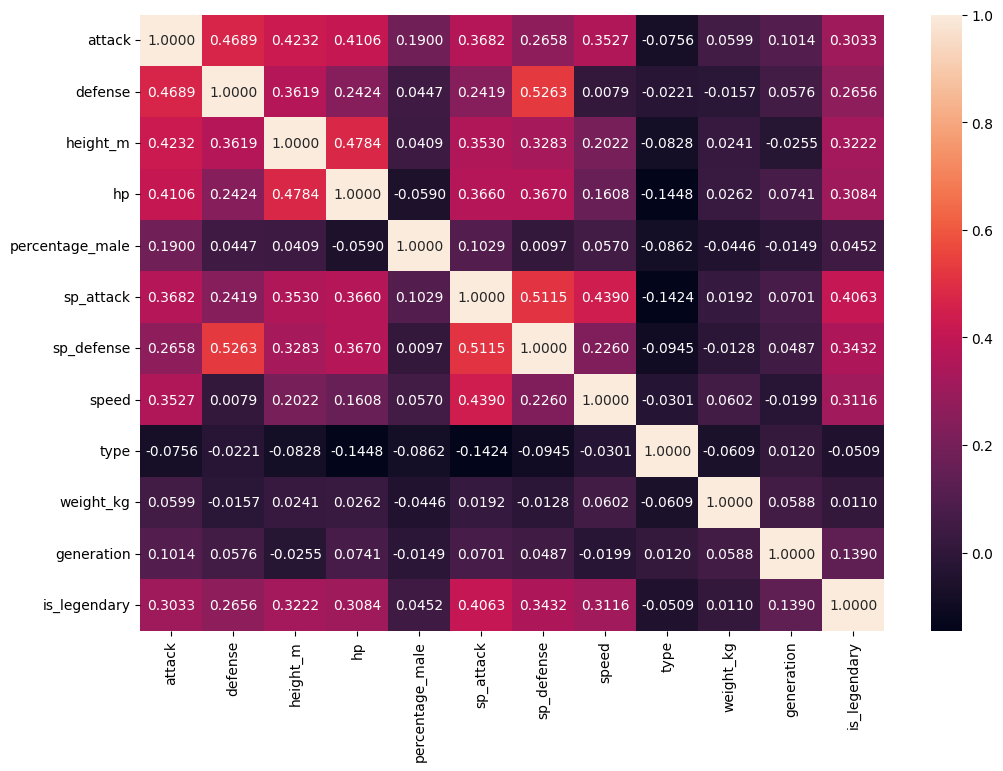

In [ ]:
df_corr = df.copy()
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse_output=False)
cat = df[['type']]
df['type']=onehot.fit_transform(cat) #converting the type column to a numerical label
corr_features = df.select_dtypes(include=np.number)  #selecting the numerical columns
corr_values = corr_features.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_values,annot=True,fmt='.4f')

In [ ]:
df.groupby('generation')['is_legendary'].sum()

,is_legendary
generation,
1,5
2,6
3,10
4,13
5,13
6,6
7,17


In [ ]:
df.groupby('generation').size()

,0
generation,
1,151
2,100
3,135
4,107
5,156
6,72
7,80


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [ ]:
num_attribs = ['hp','attack','defense','sp_attack','sp_defense','speed','height_m','weight_kg']
cat_attribs = ['type']

In [ ]:
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
cat_pipeline = Pipeline([
    ('encoder',OneHotEncoder(sparse_output=False))
])

In [ ]:
preprocess_pipeline = ColumnTransformer([
    ('num',num_pipeline,num_attribs),
    ('cat',cat_pipeline,cat_attribs)
])

In [ ]:
df.drop('name',axis=1,inplace=True)

In [ ]:
df_processed = preprocess_pipeline.fit_transform(df)

### KMEANS Implementation

In [ ]:
def distance(X,centroids):
  diff = X[:, np.newaxis, :] - centroids[np.newaxis, :, :]
  distances = np.sqrt(np.sum(diff ** 2, axis=2))
  return distances

In [ ]:
def assign_centroids(X,k):
  n = X.shape[0]  #number of rows
  indices = np.random.choice(n,k,replace=False) #chooses k centroids from n points
  return X[indices]

In [ ]:
def assign_clusters(X,centroids):
  distances = distance(X,centroids)
  labels = np.argmin(distances,axis=1)  #assign clusters to the data points with minimum distances from centroids
  return labels

In [ ]:
def update_centroids(X,k,labels):
  features = X.shape[1]
  new_centroids = np.zeros((k,features))
  for i in range(k):
    points = X[labels==i] #gives all the points that belong to cluster[i]
    new_centroids[i] = np.mean(points,axis=0) #computes the mean of the points and assigns the new centroid
  return new_centroids


In [ ]:
def Kmeans(X,k,max_iter=1000):
  centroids = assign_centroids(X,k)
  for i in range(max_iter):
    labels = assign_clusters(X,centroids)
    new_centroids = update_centroids(X,k,labels)
    centroids = new_centroids
  return centroids,labels

In [ ]:
centroid,labels =Kmeans(df_processed,4)

In [ ]:
def plot_clusters(X,labels):
  plt.scatter(X[:,0],X[:,1],c=labels,alpha=0.7,s=20)
  plt.show()

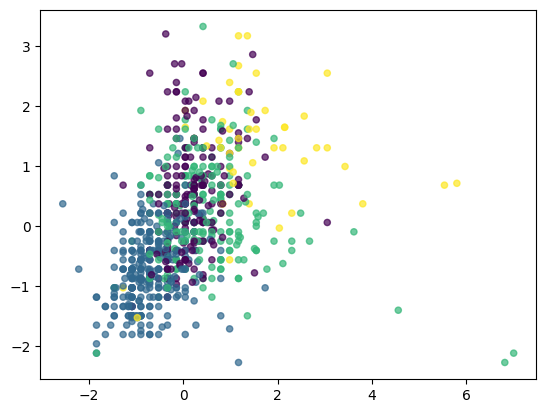

In [ ]:
plot_clusters(df_processed,labels)

### DBSCAN Implementaion

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def dbscan(X, eps, min_pts):
    n = X.shape[0]
    labels = np.full(n, -1, dtype=int)  # -1 for noise, positive integers for clusters
    visited = np.full(n, False, dtype=bool)
    cluster_id = 0

    dist_matrix = distance(X,X)

    for i in range(n):
        if visited[i]:
            continue

        visited[i] = True

        neighbors = np.where(dist_matrix[i] <= eps)[0]  # Find neighbors

        if len(neighbors) < min_pts:  # Check if the point is a core point
            labels[i] = -1  # Mark as noise
        else:
            expand_cluster(i, neighbors, cluster_id, visited, labels, dist_matrix, eps, min_pts)
            cluster_id += 1

    return labels

In [ ]:
def expand_cluster(point_index, neighbors, cluster_id, visited, labels, dist_matrix,eps, min_pts):
    labels[point_index] = cluster_id

    i = 0
    while i < len(neighbors):
        neighbor_index = neighbors[i]


        if not visited[neighbor_index]: # Check unvisited neighbors
            visited[neighbor_index] = True

            new_neighbors = np.where(dist_matrix[neighbor_index] <= eps)[0] #finds its neighbors

            # If the neighbor is also a core point, add its neighbors to the cluster
            if len(new_neighbors) >= min_pts:
                neighbors = np.unique(np.concatenate((neighbors, new_neighbors)))

        # Assign the cluster label to non core points
        if labels[neighbor_index] == -1 or labels[neighbor_index] < 0:
            labels[neighbor_index] = cluster_id

        i += 1

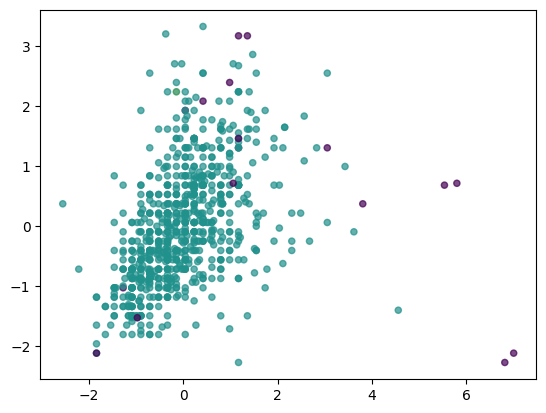

In [ ]:
cluster_id=dbscan(df_processed,3.5,10)
plot_clusters(df_processed,cluster_id)